In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Don't change file path. Make sure data files are in the previous directory of git repo i.e. csv files should be in `xx` of `xx\Cornell-Trinity-Project`

In [36]:
# a_claim = pd.read_csv('../A_CLAIM.csv')
b_claim_icd = pd.read_csv('../B_CLAIM_ICD.csv')
# c_enrollment = pd.read_csv(../'C_Enrollment.csv')
# d_npi_claim_xref = pd.read_csv('../D_NPI_CLAIM_XREF.csv')
e_patient = pd.read_csv('../E_PATIENT.csv')
# f_revenue = pd.read_csv('../F_REVENUE.csv')

# Preprocessing

## 1. Converting all ICD-9 codes to ICD-10

In [37]:
diag_conv = pd.read_csv('conversion/D_codes_conv.csv')
proc_conv = pd.read_csv('conversion/P_codes_conv.csv')
d_dict = dict(zip(diag_conv['icd9'], diag_conv['icd10']))
p_dict = dict(zip(proc_conv['ICD-9'], proc_conv['ICD-10']))
b = b_claim_icd.copy()
b.loc[(b['CODE_VERSION'] == 9)&(b['CODE_FLAG']=='D'), 'ICD_CODE'] = b.loc[(b['CODE_VERSION'] == 9)&(b['CODE_FLAG']=='D'), 'ICD_CODE'].map(d_dict)
b.loc[(b['CODE_VERSION'] == 9)&(b['CODE_FLAG']=='P'), 'ICD_CODE'] = b.loc[(b['CODE_VERSION'] == 9)&(b['CODE_FLAG']=='P'), 'ICD_CODE'].map(p_dict)

`b` is a copy of the original `B_CLAIM_ICD` dataset with icd 9 codes converted. <br>
`'CODE_VERSION'` is unchanged. <br>
Around ~1600 entries missing, mostly due to original code missing

## 2. Formating data types

In [38]:
b['SRVC_FROM_DATE'] = pd.to_datetime(b['SRVC_FROM_DATE'])
b['SRVC_THRU_DATE'] = pd.to_datetime(b['SRVC_THRU_DATE'])

Service duration / therapy duration ranges from 136 days to 0 days

## 3. Imputing missing intermidiate stages

In [39]:
# Generally all codes map onto their stages, all N183s match to stage 3
# 0 = Unspecified

stages = {"N181": 1, "N182": 2, "N183": 3, "N1830": 3, "N1831": 3, "N1832": 3, 
          "N184": 4, "N185": 5, "N186": 6, "N189": 0}

# Get rows only for patients with CKD 
B_CKD = (b[b["ICD_CODE"].str.startswith("N18", na=False)]).copy()

B_CKD["code_stage_conversion"] = B_CKD["ICD_CODE"].map(stages)

# Drop records with unspecified stages 
# B_CKD = B_CKD[B_CKD["code_stage_conversion"] != 0]
B_CKD_dateasindex = B_CKD.copy()
B_CKD_dateasindex.set_index('SRVC_THRU_DATE', inplace=True)

In [40]:
# B_CKD[B_CKD["code_stage_conversion"] == 0].groupby('PATIENT_ID').count().sort_values("CLAIM_NUMBER",ascending=False)

<AxesSubplot:xlabel='SRVC_THRU_DATE'>

<Figure size 2000x500 with 0 Axes>

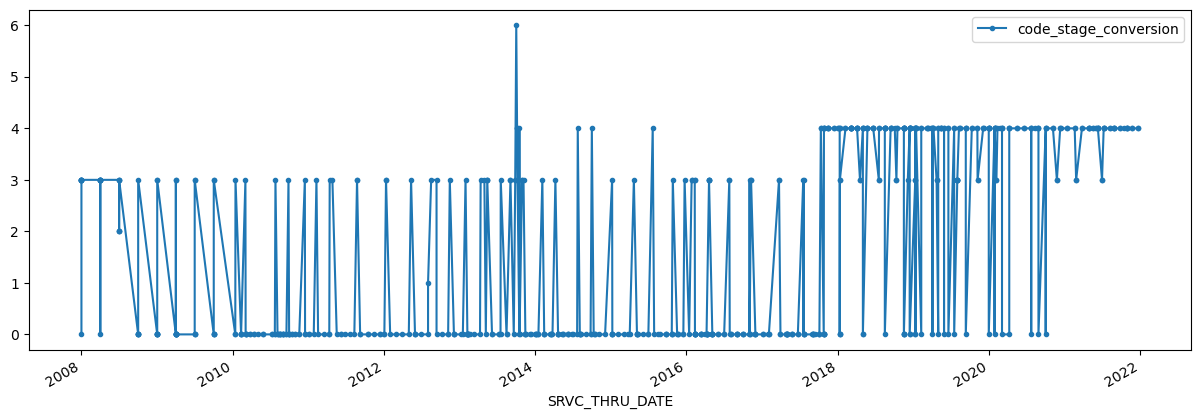

In [41]:
plt.figure(figsize=(20,5))
B_CKD_dateasindex[B_CKD_dateasindex['PATIENT_ID'] == 102726969].plot(y='code_stage_conversion', marker='.', figsize=(15, 5))

Safe to drop all unspecified stages

In [42]:
B_CKD = B_CKD[B_CKD["code_stage_conversion"] != 0]
B_CKD_dateasindex = B_CKD.copy()
B_CKD_dateasindex.set_index('SRVC_THRU_DATE', inplace=True)

<AxesSubplot:xlabel='SRVC_THRU_DATE'>

<Figure size 2000x500 with 0 Axes>

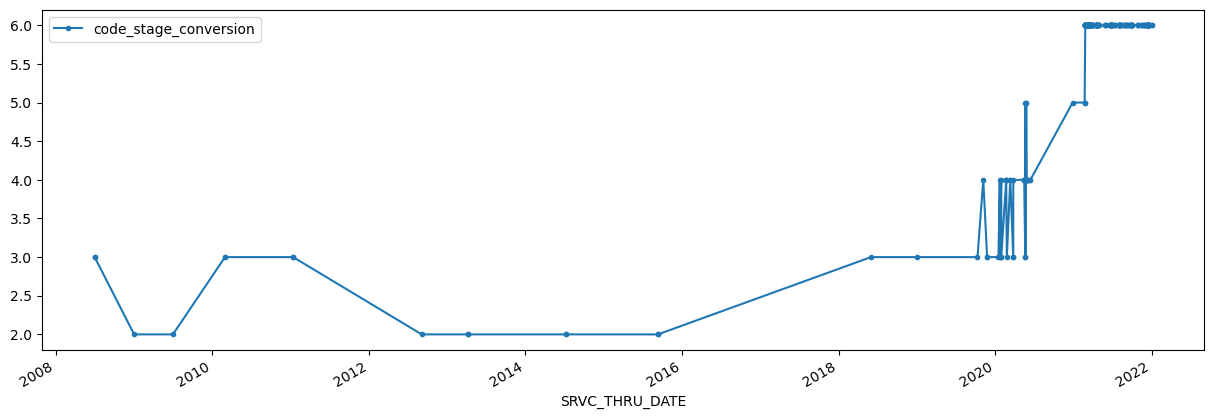

In [43]:
# Example: stages of patient 101742105 over time 

plt.figure(figsize=(20,5))
B_CKD_dateasindex[B_CKD_dateasindex['PATIENT_ID'] == 101742105].plot(y='code_stage_conversion', marker='.', figsize=(15, 5))

## 4. Adding more features

In [44]:
ckd_id = B_CKD['PATIENT_ID'].unique()
# B_CKD is ckd records only, b_ckd_patient gives all records including other diseases of ckd patients
b_ckd_patient = b[b['PATIENT_ID'].isin(ckd_id)]
# b_ckd_patient

In [45]:
# temp = b_ckd_patient.copy()
# temp.drop_duplicates(subset=['ICD_CODE', 'PATIENT_ID']).groupby(by=['ICD_CODE']).count().sort_values('PATIENT_ID', ascending=False).head(15)

Co-occurances to consider:

|Code      | Description |
| ----------- | ----------- |
| I10      |Essential (Primary) Hypertension      |
| Z23   |Encounter for immunization|
| E785   |Hyperlipidemia, unspecified|
|R079  |Chest pain, unspecified|
| D649|Anemia, unspecified|
|Z0000|Encounter for general adult medical examination without abnormal findings|
|R0602|Shortness of breath|
|Z79899|Other long term (current) drug therapy|
|R05|Cough|
|N390|Urinary tract infection, site not specified|
|I129|Hypertensive chronic kidney disease w stg 1-4|
|E780|Pure hypercholesterolemia|
|M545|Low back pain|

In [46]:
# add demographic info from E_PATIENT dataset
# The result dataset contains demographic info for 4999 patients with their ID, sex, race, and age
# join this df to other df by the PATIENT_ID
e = e_patient[['PATIENT_ID','SEX_DESC','RACE_DESC', 'AGE']].copy()
demo = e.groupby('PATIENT_ID').agg({'SEX_DESC':'first','RACE_DESC':'first','AGE':'mean'}).reset_index()
demo['AGE'] = demo['AGE'].astype('int')
# demo

In [47]:
# filter demo matrix by 4553 ckd patients
feature_matrix = demo[demo['PATIENT_ID'].isin(ckd_id)]

In [48]:
earliest_ckd = B_CKD.sort_values('SRVC_FROM_DATE', ascending=True).drop_duplicates('PATIENT_ID')
feature_matrix = feature_matrix.merge(earliest_ckd[['PATIENT_ID','SRVC_FROM_DATE']], on='PATIENT_ID')
# feature_matrix['EARLIEST_CKD'] = earliest_ckd[(earliest_ckd['PATIENT_ID'] == feature_matrix['PATIENT_ID']), 'SRVC_FROM_DATE']
feature_matrix.rename(columns={'SRVC_FROM_DATE':'EARLIEST_CKD_DATE'}, inplace=True)
feature_matrix

,PATIENT_ID,SEX_DESC,RACE_DESC,AGE,EARLIEST_CKD_DATE
0,101712851,Male,White,85,2014-02-05
1,101713159,Female,White,87,2013-06-03
2,101714825,Female,White,82,2018-05-02
3,101716339,Male,White,81,2021-03-02
4,101716389,Female,White,77,2019-07-01
...,...,...,...,...,...
4548,102931573,Female,White,76,2011-12-01
4549,102931596,Female,White,76,2021-04-13
4550,102931787,Female,White,76,2016-05-25
4551,102931876,Female,White,76,2008-04-01


In [49]:
def had_disease(b_ckd, icd_code, icd_desc):
    """
    returns records of queried disease that took place before first ckd diagnosis
    changes the feature matrix by adding a 'had_[disease]' column
    
    @params
    b_ckd : dataframe
        here it should be b_ckd_patient, the complete medical record of all 4553 ckd patients
    icd_code : str
    icd_desc : str
    
    """
    df = (b_ckd[b_ckd["ICD_CODE"].str.startswith(icd_code, na=False)]).copy()
    df = df.merge(feature_matrix[['PATIENT_ID','EARLIEST_CKD_DATE']], on='PATIENT_ID')
    df = df[df['SRVC_FROM_DATE']<=df['EARLIEST_CKD_DATE']]
    colname = 'had_'+icd_desc
    feature_matrix[colname] = feature_matrix['PATIENT_ID'].isin(df.PATIENT_ID)
    df = df[['PATIENT_ID', 'SRVC_FROM_DATE', 'SRVC_THRU_DATE', 'ICD_CODE', 'ICD_DESC','EARLIEST_CKD_DATE']]
    return df

In [50]:
# usage as follows:
hyperlipidemia_records = had_disease(b_ckd_patient, 'E78', 'hyperlipidemia')
feature_matrix['had_hyperlipidemia']

0       True
1       True
2       True
3       True
4       True
        ... 
4548    True
4549    True
4550    True
4551    True
4552    True
Name: had_hyperlipidemia, Length: 4553, dtype: bool

In [51]:
had_disease(b_ckd_patient, 'I10', 'hypertension')
had_disease(b_ckd_patient, 'R07', 'chest_throat_pain')
had_disease(b_ckd_patient, 'D64', 'anemia')
had_disease(b_ckd_patient, 'R06', 'dyspnea')
had_disease(b_ckd_patient, 'R05', 'cough')
had_disease(b_ckd_patient, 'N39', 'urinary_tract_infection')
had_disease(b_ckd_patient, 'M545', 'low_back_pain')
had_disease(b_ckd_patient, 'E08', 'diabetes_underlying_condition')
had_disease(b_ckd_patient, 'E09', 'diabete_drug_chemical')
had_disease(b_ckd_patient, 'E10', 'diabetes_type1')
had_disease(b_ckd_patient, 'E11', 'diabetes_type2')
had_disease(b_ckd_patient, 'E13', 'diabetes_other')

,PATIENT_ID,SRVC_FROM_DATE,SRVC_THRU_DATE,ICD_CODE,ICD_DESC,EARLIEST_CKD_DATE
0,102068841,2016-05-31,2016-05-31,E139,OTH SPCFD DM W/O COMPLICATIONS,2017-09-19
1,102068841,2016-12-15,2016-12-15,E139,OTH SPCFD DM W/O COMPLICATIONS,2017-09-19
2,102068841,2016-05-24,2016-05-24,E139,OTH SPCFD DM W/O COMPLICATIONS,2017-09-19
3,102068841,2016-03-21,2016-03-21,E139,OTH SPCFD DM W/O COMPLICATIONS,2017-09-19
4,102068841,2016-02-23,2016-02-23,E139,OTH SPCFD DM W/O COMPLICATIONS,2017-09-19
...,...,...,...,...,...,...
2077,102848335,2018-10-22,2018-10-22,E139,OTH SPCFD DM W/O COMPLICATIONS,2021-10-01
2080,102749327,2016-02-23,2016-02-23,E139,OTH SPCFD DM W/O COMPLICATIONS,2019-09-30
2081,102139283,2017-05-24,2017-05-24,E139,OTH SPCFD DM W/O COMPLICATIONS,2021-06-22
2085,102289879,2017-03-09,2017-03-09,E1343,OTH SPCFD DM W DBTC AUTON NEUROPTHY,2017-09-05


In [52]:
feature_matrix

,PATIENT_ID,SEX_DESC,RACE_DESC,AGE,EARLIEST_CKD_DATE,had_hyperlipidemia,had_hypertension,had_chest_throat_pain,had_anemia,had_dyspnea,had_cough,had_urinary_tract_infection,had_low_back_pain,had_diabetes_underlying_condition,had_diabete_drug_chemical,had_diabetes_type1,had_diabetes_type2,had_diabetes_other
0,101712851,Male,White,85,2014-02-05,True,True,True,True,False,True,False,False,False,False,False,False,False
1,101713159,Female,White,87,2013-06-03,True,True,True,True,True,True,True,True,False,False,False,False,False
2,101714825,Female,White,82,2018-05-02,True,True,False,False,False,False,False,False,False,False,False,False,False
3,101716339,Male,White,81,2021-03-02,True,True,True,True,True,True,True,True,False,False,False,True,False
4,101716389,Female,White,77,2019-07-01,True,True,True,True,True,True,True,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4548,102931573,Female,White,76,2011-12-01,True,True,True,True,True,False,True,True,False,False,True,True,False
4549,102931596,Female,White,76,2021-04-13,True,True,True,True,True,False,True,True,False,False,False,False,False
4550,102931787,Female,White,76,2016-05-25,True,True,False,False,False,False,False,False,False,False,False,False,False
4551,102931876,Female,White,76,2008-04-01,True,True,False,True,True,False,True,False,False,False,True,True,False


In [19]:
# Find patients with both ICD codes
patient_df = b[b['ICD_CODE'].str.startswith(('E08','E09','E10','E11','E12')) | b['ICD_CODE'].str.startswith('I10')]
patient_ids = patient_df.groupby('PATIENT_ID').filter(lambda x: x['ICD_CODE'].str.startswith(('E08','E09','E10','E11','E12')).any() and x['ICD_CODE'].str.startswith('I10').any())['PATIENT_ID'].unique()

# Calculate maximum and avg overlap duration for each patient
overlap_duration_df = pd.DataFrame(columns=['PATIENT_ID', 'MAX_OVERLAP_DURATION', 'AVG_OVERLAP_DURATION'])
for patient_id in patient_ids:
    overlap_durations = []
    # Get records for patient with both ICD codes (used these 5 for diabetes for now)
    patient_records = patient_df[patient_df['PATIENT_ID'] == patient_id]
    e_records = patient_records[patient_records['ICD_CODE'].str.startswith(('E08','E09','E10','E11','E12'))]
    i10_records = patient_records[patient_records['ICD_CODE'].str.startswith('I10')]
    
    # Compute all possible combinations of e and i10 records using merge
    record_pairs = e_records.merge(i10_records, on='PATIENT_ID', suffixes=('_e', '_i10'))
    record_pairs = record_pairs[(record_pairs['SRVC_FROM_DATE_e'] <= record_pairs['SRVC_THRU_DATE_i10']) &
                                (record_pairs['SRVC_FROM_DATE_i10'] <= record_pairs['SRVC_THRU_DATE_e'])]

    # Compute overlap duration for each pair of records
    record_pairs['overlap_duration'] = (record_pairs[['SRVC_THRU_DATE_i10', 'SRVC_THRU_DATE_e']].min(axis=1) - record_pairs[['SRVC_FROM_DATE_i10', 'SRVC_FROM_DATE_e']].max(axis=1)).dt.days
    record_pairs = record_pairs[record_pairs['overlap_duration'] > 0]
    
    
    if not record_pairs.empty:
        max_overlap_duration = record_pairs['overlap_duration'].max()
        avg_overlap_duration = round(record_pairs['overlap_duration'].mean(), 1)  # Modify this line for decimal places as needed
        overlap_duration_df = pd.concat([overlap_duration_df, pd.DataFrame({'PATIENT_ID': patient_id, 'MAX_OVERLAP_DURATION': max_overlap_duration, 'AVG_OVERLAP_DURATION': avg_overlap_duration}, index=[0])], ignore_index=True)
# Display results
print(overlap_duration_df)


     PATIENT_ID MAX_OVERLAP_DURATION  AVG_OVERLAP_DURATION
0     102131799                   23                   6.0
1     102037043                    4                   4.0
2     102302021                   10                   5.5
3     102729623                   20                   6.4
4     101907585                   67                  14.4
...         ...                  ...                   ...
1149  102673569                    5                   4.5
1150  102641611                    4                   4.0
1151  101795325                   10                  10.0
1152  102551987                    4                   2.7
1153  102152141                   28                  20.0

[1154 rows x 3 columns]


In [26]:
combined = pd.merge(overlap_duration_df, feature_matrix, on="PATIENT_ID")
combined

,PATIENT_ID,MAX_OVERLAP_DURATION,AVG_OVERLAP_DURATION,SEX_DESC,RACE_DESC,AGE,EARLIEST_CKD_DATE,had_hyperlipidemia,had_hypertension,had_chest_throat_pain,had_anemia,had_dyspnea,had_cough,had_urinary_tract_infection,had_low_back_pain
0,102131799,23,6.0,Female,White,66,2021-04-13,True,True,True,True,True,True,True,True
1,102037043,4,4.0,Male,White,77,2009-07-01,True,True,True,False,True,False,True,False
2,102729623,20,6.4,Male,White,76,2016-01-13,True,True,True,True,True,True,True,True
3,101907585,67,14.4,Male,Asian,55,2015-10-09,True,True,True,False,True,True,True,True
4,102773683,1,1.0,Male,White,76,2015-04-16,True,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057,102673569,5,4.5,Female,White,76,2021-03-16,True,True,True,False,True,True,True,True
1058,102641611,4,4.0,Male,White,76,2017-11-08,True,True,False,True,True,True,True,False
1059,101795325,10,10.0,Male,White,87,2016-09-28,True,True,True,True,True,True,True,True
1060,102551987,4,2.7,Male,Black,83,2015-02-11,True,True,False,False,False,False,False,False


In [27]:
combined = pd.merge(feature_matrix, overlap_duration_df, on='PATIENT_ID', how='outer')

combined['MAX_OVERLAP_DURATION'].fillna(0, inplace=True)
combined['AVG_OVERLAP_DURATION'].fillna(0, inplace=True)
combined

C:\Users\Cornell5\AppData\Local\Temp\4/ipykernel_10676/3981124325.py:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  combined = pd.merge(feature_matrix, overlap_duration_df, on='PATIENT_ID', how='outer')
C:\ProgramData\Anaconda3\lib\site-packages\IPython\lib\pretty.py:700: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\formatters.py:345: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,PATIENT_ID,SEX_DESC,RACE_DESC,AGE,EARLIEST_CKD_DATE,had_hyperlipidemia,had_hypertension,had_chest_throat_pain,had_anemia,had_dyspnea,had_cough,had_urinary_tract_infection,had_low_back_pain,MAX_OVERLAP_DURATION,AVG_OVERLAP_DURATION
0,101712851.0,Male,White,85.0,2014-02-05,True,True,True,True,False,True,False,False,0,0.0
1,101713159.0,Female,White,87.0,2013-06-03,True,True,True,True,True,True,True,True,0,0.0
2,101714825.0,Female,White,82.0,2018-05-02,True,True,False,False,False,False,False,False,0,0.0
3,101716339.0,Male,White,81.0,2021-03-02,True,True,True,True,True,True,True,True,0,0.0
4,101716389.0,Female,White,77.0,2019-07-01,True,True,True,True,True,True,True,True,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4640,102553269,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,14.7
4641,102797369,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0
4642,102083817,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,8.2
4643,102102749,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,13.0


In [20]:
# we see lots of overlap even for a single patient

In [21]:
# There is multiple accounts of the same hypertension code in a single patient
(b[(b["PATIENT_ID"] == 102131799) & (b['ICD_CODE'] == 'E1151')])

,TPI_CLAIM_ID,PATIENT_ID,CLAIM_NUMBER,SRVC_FROM_DATE,SRVC_THRU_DATE,ICD_CODE,ICD_DESC,CODE_FLAG,CODE_VERSION,CODE_FLAG_FULL,FACILITY_PROFESSIONAL_INDICATOR
32,1021317993075806IP2020,102131799,3075806,2020-05-03,2020-05-06,E1151,Type 2 diabetes mellitus with diabetic periphe...,D,10.0,Diag - 3,F
441805,10213179984143165OP2020,102131799,84143165,2020-08-25,2020-08-25,E1151,Type 2 diabetes mellitus with diabetic periphe...,D,10.0,Diag - 3,F
921674,10213179939859607PO2006,102131799,39859607,2006-10-01,2006-10-01,E1151,"DM w/crcltry dsord, type II",D,9.0,NaN,P
926338,1021317995735189IP2021,102131799,5735189,2021-09-06,2021-09-13,E1151,Type 2 diabetes mellitus with diabetic periphe...,D,10.0,Diag - 13,F
966155,102131799984192PO2013,102131799,984192,2013-12-18,2013-12-18,E1151,"DM w/crcltry dsord, type II",D,9.0,NaN,P
1263277,1021317991021205PO2012,102131799,1021205,2012-05-24,2012-05-24,E1151,"DM w/crcltry dsord, type II",D,9.0,NaN,P
1628910,102131799949928PO2014,102131799,949928,2014-02-26,2014-02-26,E1151,"DM w/crcltry dsord, type II",D,9.0,NaN,P
1731198,1021317997430763IP2020,102131799,7430763,2020-11-22,2020-11-26,E1151,Type 2 diabetes mellitus with diabetic periphe...,D,10.0,Diag - 16,F
1867574,10213179984143164OP2020,102131799,84143164,2020-08-20,2020-08-20,E1151,Type 2 diabetes mellitus with diabetic periphe...,D,10.0,Diag - 3,F
1972912,1021317997785341IP2021,102131799,7785341,2021-11-30,2021-12-02,E1151,Type 2 diabetes mellitus with diabetic periphe...,D,10.0,Diag - 9,F


### Diabetes
#### Generally, there are five types of Diabetes
    E08, Diabetes mellitus due to underlying condition
    E09, Drug or chemical induced diabetes mellitus
    E10, Type 1 diabetes mellitus
    E11, Type 2 diabetes mellitus
    E13, Other specified diabetes mellitus

In [53]:
# example of Type 2 Diabete entries in data
Diabete_2 = (b[b["ICD_CODE"].str.startswith('E11', na=False)]).copy()
Diabete_2.head(20).ICD_CODE

# There are mutiple variation of Type 2 Diabete ICD code
# this happends to all E08 to E13

32       E1151
33       E1159
34      E11621
35      E11649
36       E1165
66       E1151
150    E113513
151      E1140
152      E1140
198    E113593
199      E1140
220      E1129
221    E113312
301      E1169
302      E1169
303      E1169
304      E1169
305      E1169
306      E1169
307       E118
Name: ICD_CODE, dtype: object

In [54]:
# # Diabetes mellitus due to underlying condition
# Diabete_3 = [x for x in temp if x.startswith('E08')]
# print(len(Diabete_3))
# # Drug or chemical induced diabetes mellitus
# Diabete_4 = [x for x in temp if x.startswith('E09')]
# print(len(Diabete_4))
# # Type 1 
# Diabete_1 = [x for x in temp if x.startswith('E10')]
# print(len(Diabete_1))
# # Type 2 
# Diabete_2 = [x for x in temp if x.startswith('E11')]
# print(len(Diabete_2))
# # Other specified diabetes mellitus
# Diabete_5 = [x for x in temp if x.startswith('E13')]
# print(len(Diabete_5))

In [55]:
fm = feature_matrix[['PATIENT_ID', 'EARLIEST_CKD_DATE']].copy()
fm

,PATIENT_ID,EARLIEST_CKD_DATE
0,101712851,2014-02-05
1,101713159,2013-06-03
2,101714825,2018-05-02
3,101716339,2021-03-02
4,101716389,2019-07-01
...,...,...
4548,102931573,2011-12-01
4549,102931596,2021-04-13
4550,102931787,2016-05-25
4551,102931876,2008-04-01


In [56]:
# Ignore the variation within each type of Diabetes for now 
# create a dataframe with Patient ID and original Diabetes ICD code
temp_df = b_ckd_patient[['PATIENT_ID','ICD_CODE','SRVC_FROM_DATE']].copy()
temp_df['ICD_CODE'] = temp_df['ICD_CODE'].astype(str)
#Diabetes_df= pd.DataFrame()

temp_df['Diabetes'] = temp_df['ICD_CODE'].apply(lambda x: 'E08' if x.startswith('E08') 
                                                    else 'E09' if x.startswith('E09')
                                                    else 'E10' if x.startswith('E10')
                                                    else 'E11' if x.startswith('E11')
                                                    else 'E13' if x.startswith('E13')
                                                    else "Not Diabetes")

#temp_df['Diabetes_E09'] = temp_df['ICD_CODE'].apply(lambda x: 1 if x.startswith('E09') else 0)
#temp_df['Diabetes_E10_Type1'] = temp_df['ICD_CODE'].apply(lambda x: 1 if x.startswith('E10') else 0)    
#temp_df['Diabetes_E11_Type2'] = temp_df['ICD_CODE'].apply(lambda x: 1 if x.startswith('E11') else 0)  
#temp_df['Diabetes_E12'] = temp_df['ICD_CODE'].apply(lambda x: 1 if x.startswith('E12') else 0) 
temp_df

,PATIENT_ID,ICD_CODE,SRVC_FROM_DATE,Diabetes
0,102770709,L7632,2020-05-18,Not Diabetes
1,101944171,L7634,2020-03-02,Not Diabetes
2,102370123,L7682,2020-01-07,Not Diabetes
3,101742105,I129,2020-05-21,Not Diabetes
4,101959987,I129,2020-10-21,Not Diabetes
...,...,...,...,...
8518041,102864727,R109,2021-06-14,Not Diabetes
8518042,102893733,R109,2021-12-20,Not Diabetes
8518043,102906973,R109,2021-02-15,Not Diabetes
8518044,102923289,R109,2021-03-21,Not Diabetes


In [57]:
# merge the temp_df with the fm (columns from feature matrix)
merged_df = pd.merge(temp_df, fm, on='PATIENT_ID')
merged_df

,PATIENT_ID,ICD_CODE,SRVC_FROM_DATE,Diabetes,EARLIEST_CKD_DATE
0,102770709,L7632,2020-05-18,Not Diabetes,2020-05-18
1,102770709,H0012,2019-09-09,Not Diabetes,2020-05-18
2,102770709,Z5189,2020-08-14,Not Diabetes,2020-05-18
3,102770709,E875,2020-04-20,Not Diabetes,2020-05-18
4,102770709,I2510,2020-05-18,Not Diabetes,2020-05-18
...,...,...,...,...,...
7885259,102819269,Z23,2021-02-26,Not Diabetes,2021-04-30
7885260,102819269,C651,2021-04-30,Not Diabetes,2021-04-30
7885261,102819269,R319,2021-04-30,Not Diabetes,2021-04-30
7885262,102819269,R319,2021-04-30,Not Diabetes,2021-04-30


In [58]:
# Filter this dataframe, keep record of diagnosis happened before the EARLIEST_CKD_DATE
temp_df = merged_df[merged_df['EARLIEST_CKD_DATE'] <= merged_df['SRVC_FROM_DATE']]

In [59]:
# example of temp_df
temp_df

,PATIENT_ID,ICD_CODE,SRVC_FROM_DATE,Diabetes,EARLIEST_CKD_DATE
0,102770709,L7632,2020-05-18,Not Diabetes,2020-05-18
2,102770709,Z5189,2020-08-14,Not Diabetes,2020-05-18
4,102770709,I2510,2020-05-18,Not Diabetes,2020-05-18
15,102770709,E11649,2020-07-14,E11,2020-05-18
17,102770709,R269,2020-07-28,Not Diabetes,2020-05-18
...,...,...,...,...,...
7885257,102819269,N186,2021-04-30,Not Diabetes,2021-04-30
7885258,102819269,N029,2021-04-30,Not Diabetes,2021-04-30
7885260,102819269,C651,2021-04-30,Not Diabetes,2021-04-30
7885261,102819269,R319,2021-04-30,Not Diabetes,2021-04-30


In [60]:
diabetes_v1 = temp_df.drop_duplicates()
diabetes_v1

,PATIENT_ID,ICD_CODE,SRVC_FROM_DATE,Diabetes,EARLIEST_CKD_DATE
0,102770709,L7632,2020-05-18,Not Diabetes,2020-05-18
2,102770709,Z5189,2020-08-14,Not Diabetes,2020-05-18
4,102770709,I2510,2020-05-18,Not Diabetes,2020-05-18
15,102770709,E11649,2020-07-14,E11,2020-05-18
17,102770709,R269,2020-07-28,Not Diabetes,2020-05-18
...,...,...,...,...,...
7885255,102118121,N186,2021-03-05,Not Diabetes,2019-10-24
7885257,102819269,N186,2021-04-30,Not Diabetes,2021-04-30
7885258,102819269,N029,2021-04-30,Not Diabetes,2021-04-30
7885260,102819269,C651,2021-04-30,Not Diabetes,2021-04-30


In [61]:
# Use Pivot table
diabetes_v2 = diabetes_v1[['PATIENT_ID','Diabetes']].copy()
diabetes_v3 = diabetes_v2.pivot_table(index = "PATIENT_ID", columns = "Diabetes",aggfunc=len, fill_value=0)
diabetes_v3

Diabetes,E08,E09,E10,E11,E13,Not Diabetes
PATIENT_ID,,,,,,
101712851,0,0,0,0,0,753
101713159,0,0,0,5,0,500
101714825,0,0,0,0,0,337
101716339,0,0,0,1,0,96
101716389,0,0,0,0,0,302
...,...,...,...,...,...,...
102931573,0,0,2,109,0,1602
102931596,0,0,0,0,0,47
102931787,0,0,0,3,0,211


#### the table below shows the frequency of diabetes diagnosis happened before the first CKD diagnosis

In [62]:
# Convert the pivot table
# drop Not Diabetes
diabetes_v4 = diabetes_v3.drop('Not Diabetes', axis=1)
diabetes_v4




Diabetes,E08,E09,E10,E11,E13
PATIENT_ID,,,,,
101712851,0,0,0,0,0
101713159,0,0,0,5,0
101714825,0,0,0,0,0
101716339,0,0,0,1,0
101716389,0,0,0,0,0
...,...,...,...,...,...
102931573,0,0,2,109,0
102931596,0,0,0,0,0
102931787,0,0,0,3,0


#### the table below includes the indicator of each type of diabetes only

In [63]:
# convert the non-zero values to 1
diabetes_v5 = diabetes_v4.applymap(lambda x: 1 if x > 0 else 0)
diabetes_v5

Diabetes,E08,E09,E10,E11,E13
PATIENT_ID,,,,,
101712851,0,0,0,0,0
101713159,0,0,0,1,0
101714825,0,0,0,0,0
101716339,0,0,0,1,0
101716389,0,0,0,0,0
...,...,...,...,...,...
102931573,0,0,1,1,0
102931596,0,0,0,0,0
102931787,0,0,0,1,0


#### Create a another indicators (Diabetes_Ind) to see if patients have diabetes diagnosis before CKD diagnosis

In [64]:
diabetes_v4['Diabetes_Ind'] = np.where((diabetes_v4['E08'] > 0) | (diabetes_v4['E09']  > 0) | 
                                  (diabetes_v4['E10'] > 0)|(diabetes_v4['E11']  > 0) 
                                  |(diabetes_v4['E13']  > 0), 1, 0)
diabetes_v4 = diabetes_v4.rename(columns={'E08': 'Freq_diabetes_underlying_condition', 'E09': 'Freq_diabete_drug_chemical',
                                          'E10': 'Freq_diabetes_type1',
                                          'E11': 'Freq_diabetes_type2','E13': 'Freq_diabetes_other',})

In [65]:
diabetes_v4

Diabetes,Freq_diabetes_underlying_condition,Freq_diabete_drug_chemical,Freq_diabetes_type1,Freq_diabetes_type2,Freq_diabetes_other,Diabetes_Ind
PATIENT_ID,,,,,,
101712851,0,0,0,0,0,0
101713159,0,0,0,5,0,1
101714825,0,0,0,0,0,0
101716339,0,0,0,1,0,1
101716389,0,0,0,0,0,0
...,...,...,...,...,...,...
102931573,0,0,2,109,0,1
102931596,0,0,0,0,0,0
102931787,0,0,0,3,0,1


#### Merge diabetes_v4 with current feature matrix 

In [66]:
feature_matrix = pd.merge(diabetes_v4,feature_matrix , on='PATIENT_ID')
feature_matrix

,PATIENT_ID,Freq_diabetes_underlying_condition,Freq_diabete_drug_chemical,Freq_diabetes_type1,Freq_diabetes_type2,Freq_diabetes_other,Diabetes_Ind,SEX_DESC,RACE_DESC,AGE,...,had_anemia,had_dyspnea,had_cough,had_urinary_tract_infection,had_low_back_pain,had_diabetes_underlying_condition,had_diabete_drug_chemical,had_diabetes_type1,had_diabetes_type2,had_diabetes_other
0,101712851,0,0,0,0,0,0,Male,White,85,...,True,False,True,False,False,False,False,False,False,False
1,101713159,0,0,0,5,0,1,Female,White,87,...,True,True,True,True,True,False,False,False,False,False
2,101714825,0,0,0,0,0,0,Female,White,82,...,False,False,False,False,False,False,False,False,False,False
3,101716339,0,0,0,1,0,1,Male,White,81,...,True,True,True,True,True,False,False,False,True,False
4,101716389,0,0,0,0,0,0,Female,White,77,...,True,True,True,True,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4548,102931573,0,0,2,109,0,1,Female,White,76,...,True,True,False,True,True,False,False,True,True,False
4549,102931596,0,0,0,0,0,0,Female,White,76,...,True,True,False,True,True,False,False,False,False,False
4550,102931787,0,0,0,3,0,1,Female,White,76,...,False,False,False,False,False,False,False,False,False,False
4551,102931876,1,0,3,217,0,1,Female,White,76,...,True,True,False,True,False,False,False,True,True,False


In [ ]:
def add_indicator(df, lst):
    
    
    return df

In [ ]:
earliest_ckd = B_CKD.sort_values('SRVC_FROM_DATE', ascending=True).drop_duplicates('PATIENT_ID')
feature_matrix = feature_matrix.merge(earliest_ckd[['PATIENT_ID','SRVC_FROM_DATE']], on='PATIENT_ID')
# feature_matrix['EARLIEST_CKD'] = earliest_ckd[(earliest_ckd['PATIENT_ID'] == feature_matrix['PATIENT_ID']), 'SRVC_FROM_DATE']
feature_matrix = feature_matrix.rename(columns={'SRVC_FROM_DATE':'EARLIEST_CKD_DATE'})
feature_matrix

# Feature Selection

In [ ]:
# using regression models

In [ ]:
# Getting the y for different models 
# I pick Stage 3 to Stage 5 because these two stages have most patients 
# currently this is using loops which is not the desired way
# will make this process using pandas methods after presentation
#ckd_id = B_CKD['PATIENT_ID'].unique()
# Turning the service from date and thru date to datetime 
patient_35_df = b[b['ICD_CODE'].str.startswith('N183') | b['ICD_CODE'].str.startswith('N185')]
patient_35 = patient_35_df["PATIENT_ID"].drop_duplicates()
patient_3_df = patient_35_df[patient_35_df['ICD_CODE'].str.startswith('N183')]
p3 = patient_3_df.sort_values('SRVC_FROM_DATE', ascending=True).drop_duplicates('PATIENT_ID')

patient_5_df = patient_35_df[patient_35_df['ICD_CODE'].str.startswith('N185')]
p5 = patient_5_df.sort_values('SRVC_FROM_DATE', ascending=True).drop_duplicates('PATIENT_ID')
dict35 = {}

for i in patient_35:
    tmp = p5['SRVC_FROM_DATE'].loc[p5['PATIENT_ID'] == i] -  p3['SRVC_FROM_DATE'].loc[p3['PATIENT_ID'] == i]
    dict35[i] = tmp
    
dict35[102307959]


# NEED TO BE FIXED 
# CHANGE THIS TO INT

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x, axis=1),y, test_size=0.3)


from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(100)
model.fit(X_train, Y_train)

In [ ]:
model.score(X_test, Y_test)

In [ ]:
model.feature_importances_

# Clustering